## Census Income Project
#### Problem Statement:


### This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.
### Description of fnlwgt (final weight)
### The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-### institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. ### We use 3 sets of controls. These are:

### A single cell estimate of the population 16+ for each state.

### Controls for Hispanic Origin by age and sex.

### Controls by Race, age and sex.

### We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.



In [5]:
#import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

In [6]:
#load census data
df= pd.read_csv('census_income.csv')

print(df.shape)
df.head()


(32560, 15)


,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [7]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [8]:
df.duplicated().sum()

24

In [9]:
#Checking and removing if there is any Duplicate entry present in our dataset
df.drop_duplicates(inplace=True)
df.shape

(32536, 15)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32536 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32536 non-null  int64 
 1   Workclass       32536 non-null  object
 2   Fnlwgt          32536 non-null  int64 
 3   Education       32536 non-null  object
 4   Education_num   32536 non-null  int64 
 5   Marital_status  32536 non-null  object
 6   Occupation      32536 non-null  object
 7   Relationship    32536 non-null  object
 8   Race            32536 non-null  object
 9   Sex             32536 non-null  object
 10  Capital_gain    32536 non-null  int64 
 11  Capital_loss    32536 non-null  int64 
 12  Hours_per_week  32536 non-null  int64 
 13  Native_country  32536 non-null  object
 14  Income          32536 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [11]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32536.000000,3.253600e+04,32536.000000,32536.000000,32536.000000,32536.000000
mean,38.585536,1.897843e+05,10.081725,1078.410069,87.370912,40.440343
std,13.638193,1.055563e+05,2.571622,7388.068465,403.107737,12.347079
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369932e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
# finding categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :', categorical)


There are 9 categorical variables

The categorical variables are : ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']


In [13]:
# checking for categorical columns
categorical_columns=[]
for i in df.dtypes.index:
    if df.dtypes[i]=='object':
        categorical_columns.append(i)
print(categorical_columns)

['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']


In [14]:
pd.options.display.max_colwidth =None
col_name=[]
num=[]
feat=[]
for i in categorical_columns:
    col_name.append(i)
    num.append(len(df[i].unique()))
    feat.append(df[i].unique())
inf=pd.DataFrame({'FEATURE':col_name,"NUMBER OF UNIQUE FEATURES":num,"UNIQUE FEATURES":feat})
inf


,FEATURE,NUMBER OF UNIQUE FEATURES,UNIQUE FEATURES
0,Workclass,9,"[ Self-emp-not-inc, Private, State-gov, Federal-gov, Local-gov, ?, Self-emp-inc, Without-pay, Never-worked]"
1,Education,16,"[ Bachelors, HS-grad, 11th, Masters, 9th, Some-college, Assoc-acdm, Assoc-voc, 7th-8th, Doctorate, Prof-school, 5th-6th, 10th, 1st-4th, Preschool, 12th]"
2,Marital_status,7,"[ Married-civ-spouse, Divorced, Married-spouse-absent, Never-married, Separated, Married-AF-spouse, Widowed]"
3,Occupation,15,"[ Exec-managerial, Handlers-cleaners, Prof-specialty, Other-service, Adm-clerical, Sales, Craft-repair, Transport-moving, Farming-fishing, Machine-op-inspct, Tech-support, ?, Protective-serv, Armed-Forces, Priv-house-serv]"
4,Relationship,6,"[ Husband, Not-in-family, Wife, Own-child, Unmarried, Other-relative]"
5,Race,5,"[ White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other]"
6,Sex,2,"[ Male, Female]"
7,Native_country,42,"[ United-States, Cuba, Jamaica, India, ?, Mexico, South, Puerto-Rico, Honduras, England, Canada, Germany, Iran, Philippines, Italy, Poland, Columbia, Cambodia, Thailand, Ecuador, Laos, Taiwan, Haiti, Portugal, Dominican-Republic, El-Salvador, France, Guatemala, China, Japan, Yugoslavia, Peru, Outlying-US(Guam-USVI-etc), Scotland, Trinadad&Tobago, Greece, Nicaragua, Vietnam, Hong, Ireland, Hungary, Holand-Netherlands]"
8,Income,2,"[ <=50K, >50K]"


In [15]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :', numerical)


There are 6 numerical variables

The numerical variables are : ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


In [16]:
# checking for categorical columns
numerical_columns=[]
for i in df.dtypes.index:
    if df.dtypes[i]=='int64':
        numerical_columns.append(i)
print(numerical_columns)


['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


In [17]:
pd.options.display.max_colwidth =None
col_name=[]
num=[]
feat=[]
for i in numerical_columns:
    col_name.append(i)
    num.append(len(df[i].unique()))
    feat.append(df[i].unique())
inf=pd.DataFrame({'FEATURE':col_name,"NUMBER OF UNIQUE FEATURES":num,"UNIQUE FEATURES":feat})
inf


,FEATURE,NUMBER OF UNIQUE FEATURES,UNIQUE FEATURES
0,Age,73,"[50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43, 54, 35, 59, 56, 19, 39, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47, 46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58, 26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82, 83, 84, 85, 86, 87]"
1,Fnlwgt,21647,"[83311, 215646, 234721, 338409, 284582, 160187, 209642, 45781, 159449, 280464, 141297, 122272, 205019, 121772, 245487, 176756, 186824, 28887, 292175, 193524, 302146, 76845, 117037, 109015, 216851, 168294, 180211, 367260, 193366, 190709, 266015, 386940, 59951, 311512, 242406, 197200, 544091, 84154, 265477, 507875, 88506, 172987, 94638, 289980, 337895, 144361, 128354, 101603, 271466, 32275, 226956, 51835, 251585, 109832, 237993, 216666, 56352, 147372, 188146, 59496, 293936, 149640, 116632, 105598, 155537, 183175, 169846, 191681, 200681, 101509, 309974, 162298, 211678, 124744, 213921, 32214, 212759, 309634, 125927, 446839, 276515, 51618, 159937, 343591, 346253, 268234, 202051, 54334, 410867, 249977, 286730, 212563, 117747, 226296, 115585, 191277, 202683, 171095, 249409, 124191, ...]"
2,Education_num,16,"[13, 9, 7, 14, 5, 10, 12, 11, 4, 16, 15, 3, 6, 2, 1, 8]"
3,Capital_gain,119,"[0, 14084, 5178, 5013, 2407, 14344, 15024, 7688, 34095, 4064, 4386, 7298, 1409, 3674, 1055, 3464, 2050, 2176, 2174, 594, 20051, 6849, 4101, 1111, 8614, 3411, 2597, 25236, 4650, 9386, 2463, 3103, 10605, 2964, 3325, 2580, 3471, 4865, 99999, 6514, 1471, 2329, 2105, 2885, 25124, 10520, 2202, 2961, 27828, 6767, 2228, 1506, 13550, 2635, 5556, 4787, 3781, 3137, 3818, 3942, 914, 401, 2829, 2977, 4934, 2062, 2354, 5455, 15020, 1424, 3273, 22040, 4416, 3908, 10566, 991, 4931, 1086, 7430, 6497, 114, 7896, 2346, 3418, 3432, 2907, 1151, 2414, 2290, 15831, 41310, 4508, 2538, 3456, 6418, 1848, 3887, 5721, 9562, 1455, ...]"
4,Capital_loss,92,"[0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816, 1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721, 2051, 2377, 1669, 2352, 1672, 653, 2392, 1504, 2001, 1590, 1651, 1628, 1848, 1740, 2002, 1579, 2258, 1602, 419, 2547, 2174, 2205, 1726, 2444, 1138, 2238, 625, 213, 1539, 880, 1668, 1092, 1594, 3004, 2231, 1844, 810, 2824, 2559, 2057, 1974, 974, 2149, 1825, 1735, 1258, 2129, 2603, 2282, 323, 4356, 2246, 1617, 1648, 2489, 3770, 1755, 3683, 2267, 2080, 2457, 155, 3900, 2201, 1944, 2467, 2163, 2754, 2472, 1411]"
5,Hours_per_week,94,"[13, 40, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55, 48, 58, 32, 70, 2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65, 1, 10, 34, 75, 98, 33, 54, 8, 6, 64, 19, 18, 72, 5, 9, 47, 37, 21, 26, 14, 4, 59, 7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84, 3, 17, 68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67, 82, 86, 91, 81, 76, 92, 61, 74, 95]"


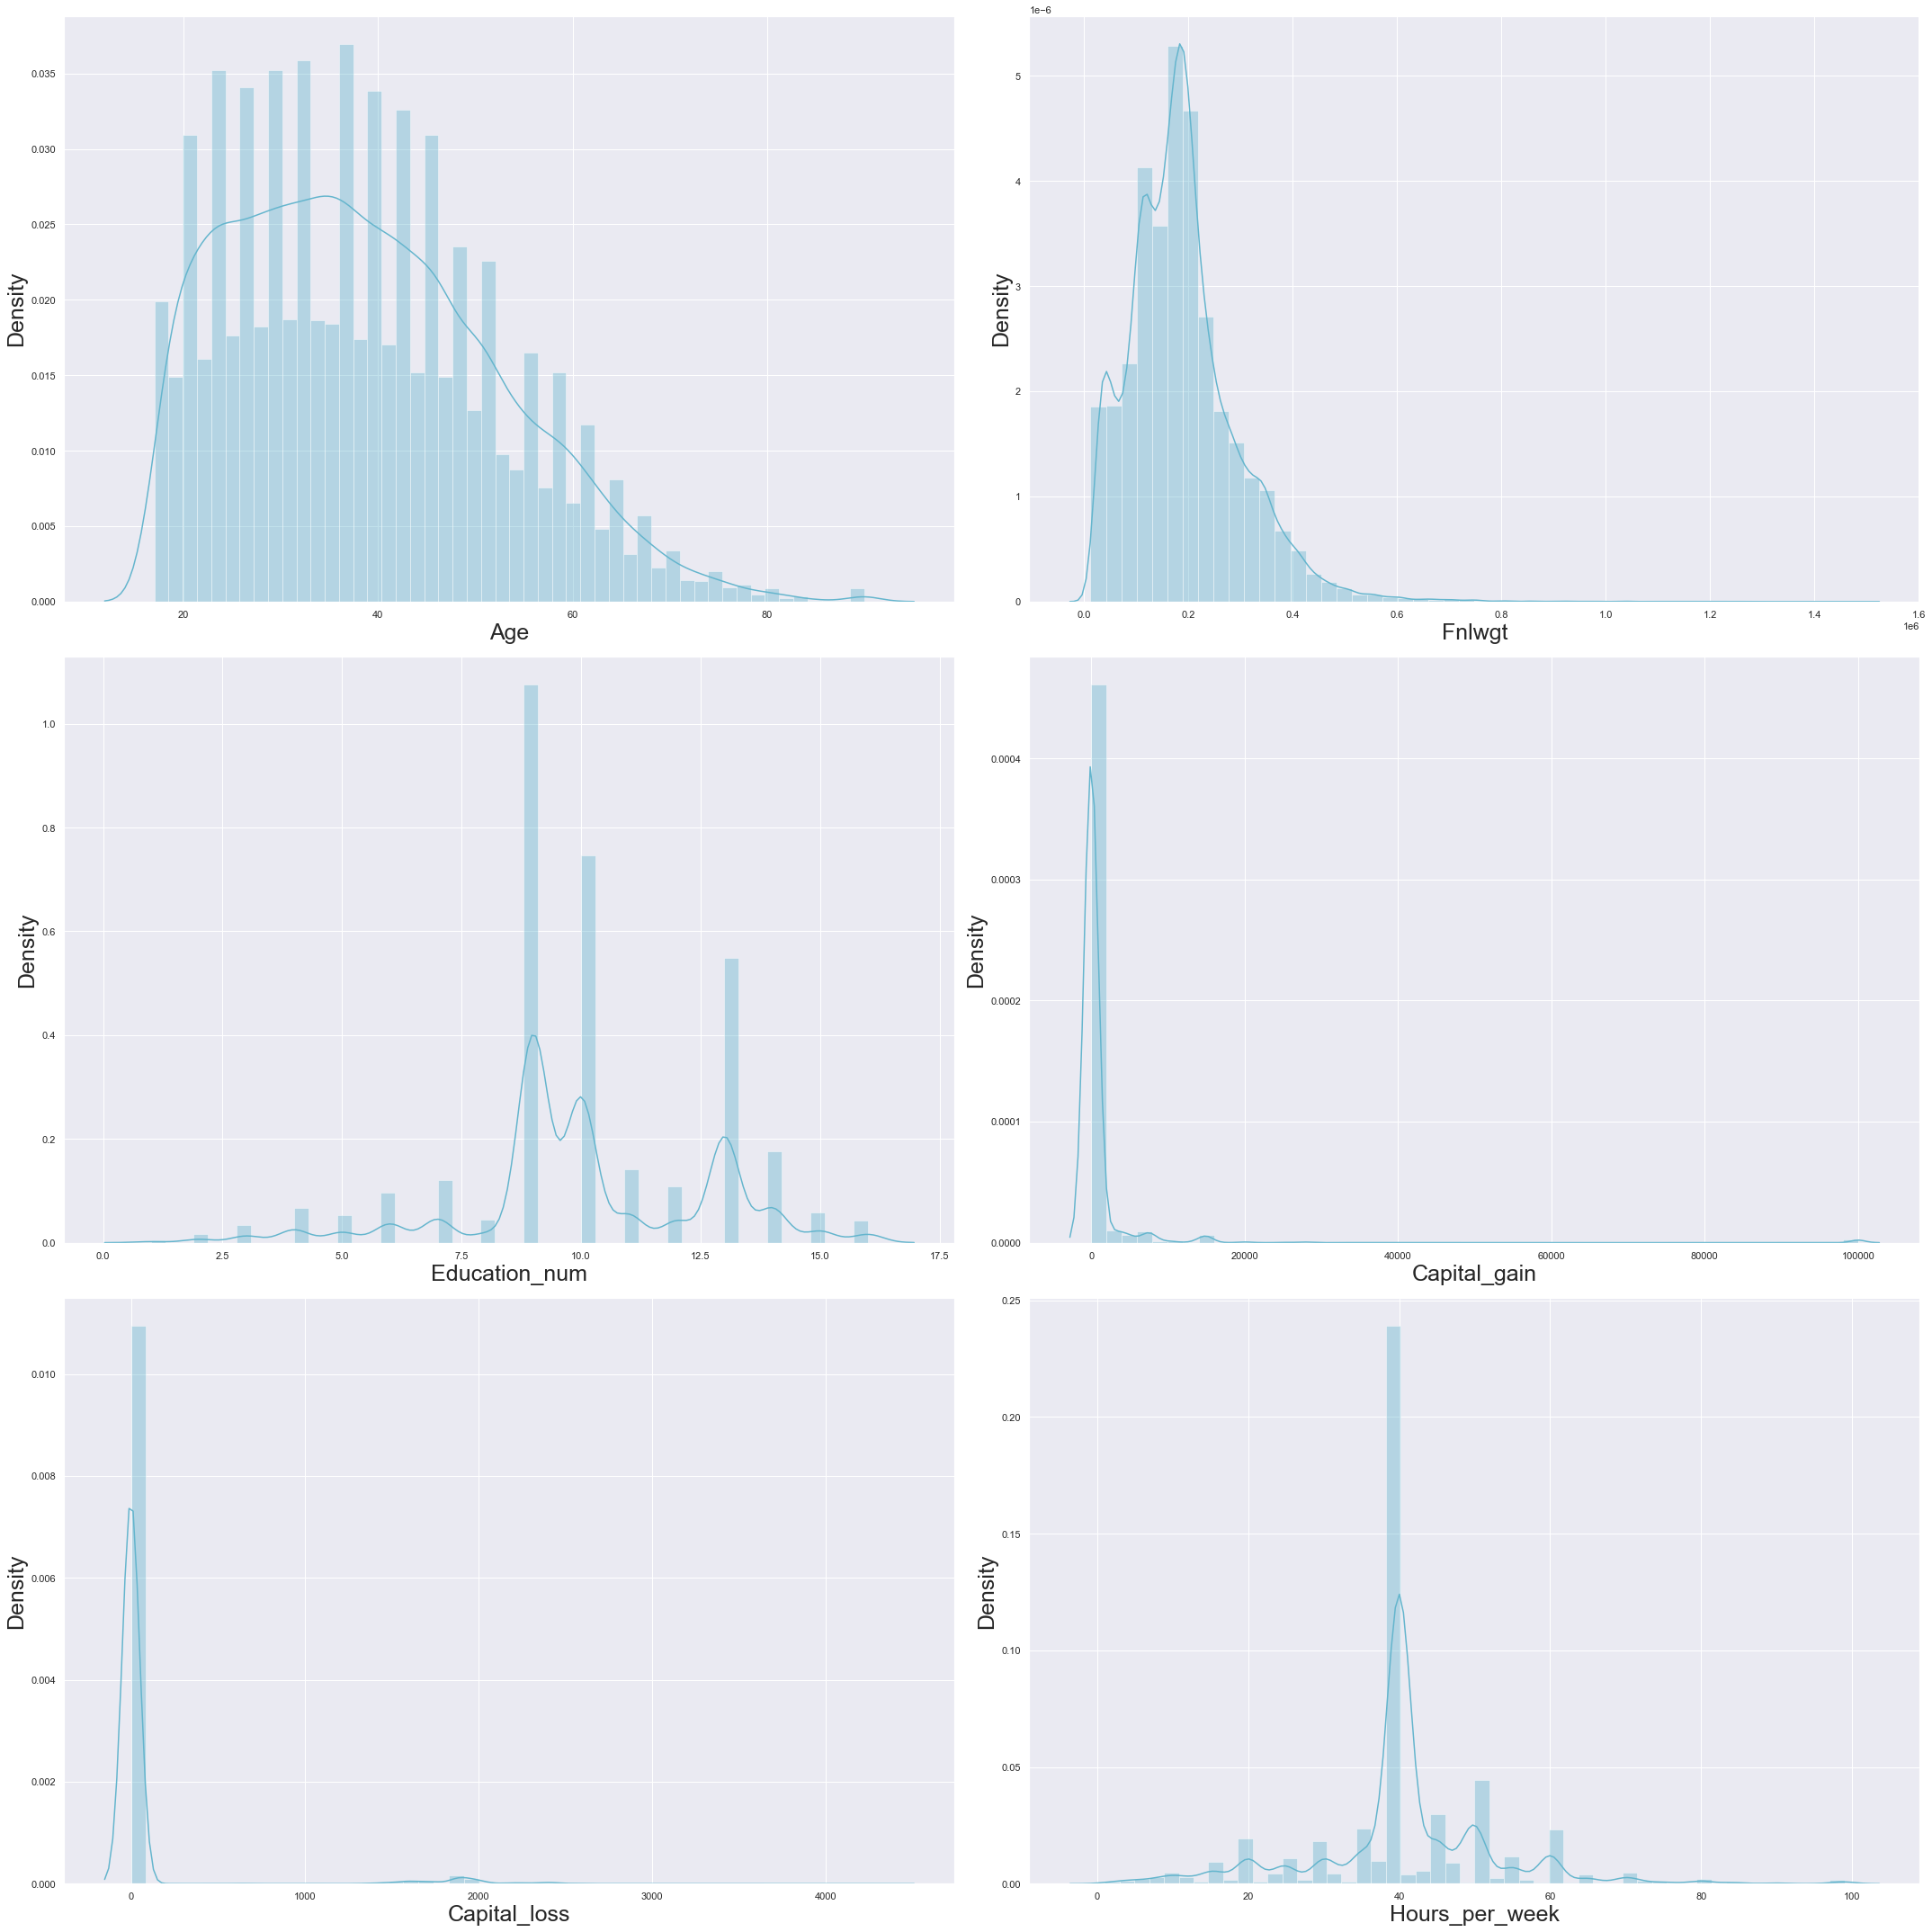

In [18]:
#Distribution plot for all numerical columns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

plt.figure(figsize = (30,30))
plotnumber = 1
for column in df[numerical_columns]:
    if plotnumber <=6:
        ax = plt.subplot(3,2,plotnumber)
        sns.distplot(df[column],color='c')
        plt.xlabel(column,fontsize = 25)
        plt.ylabel('Density',fontsize = 25)
    plotnumber+=1
plt.tight_layout()


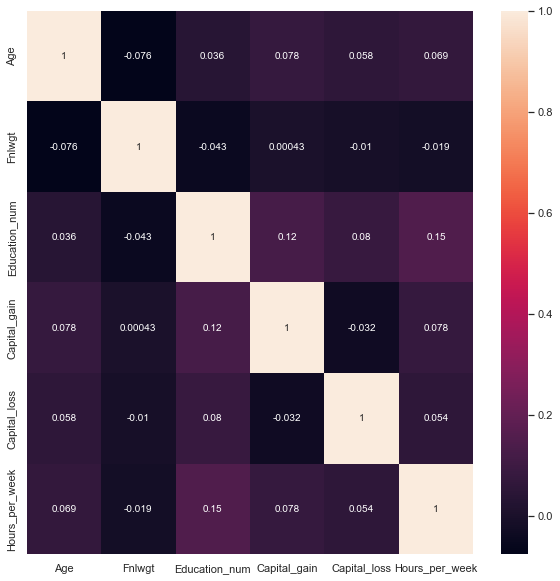

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,annot_kws={'size':10})
plt.show()

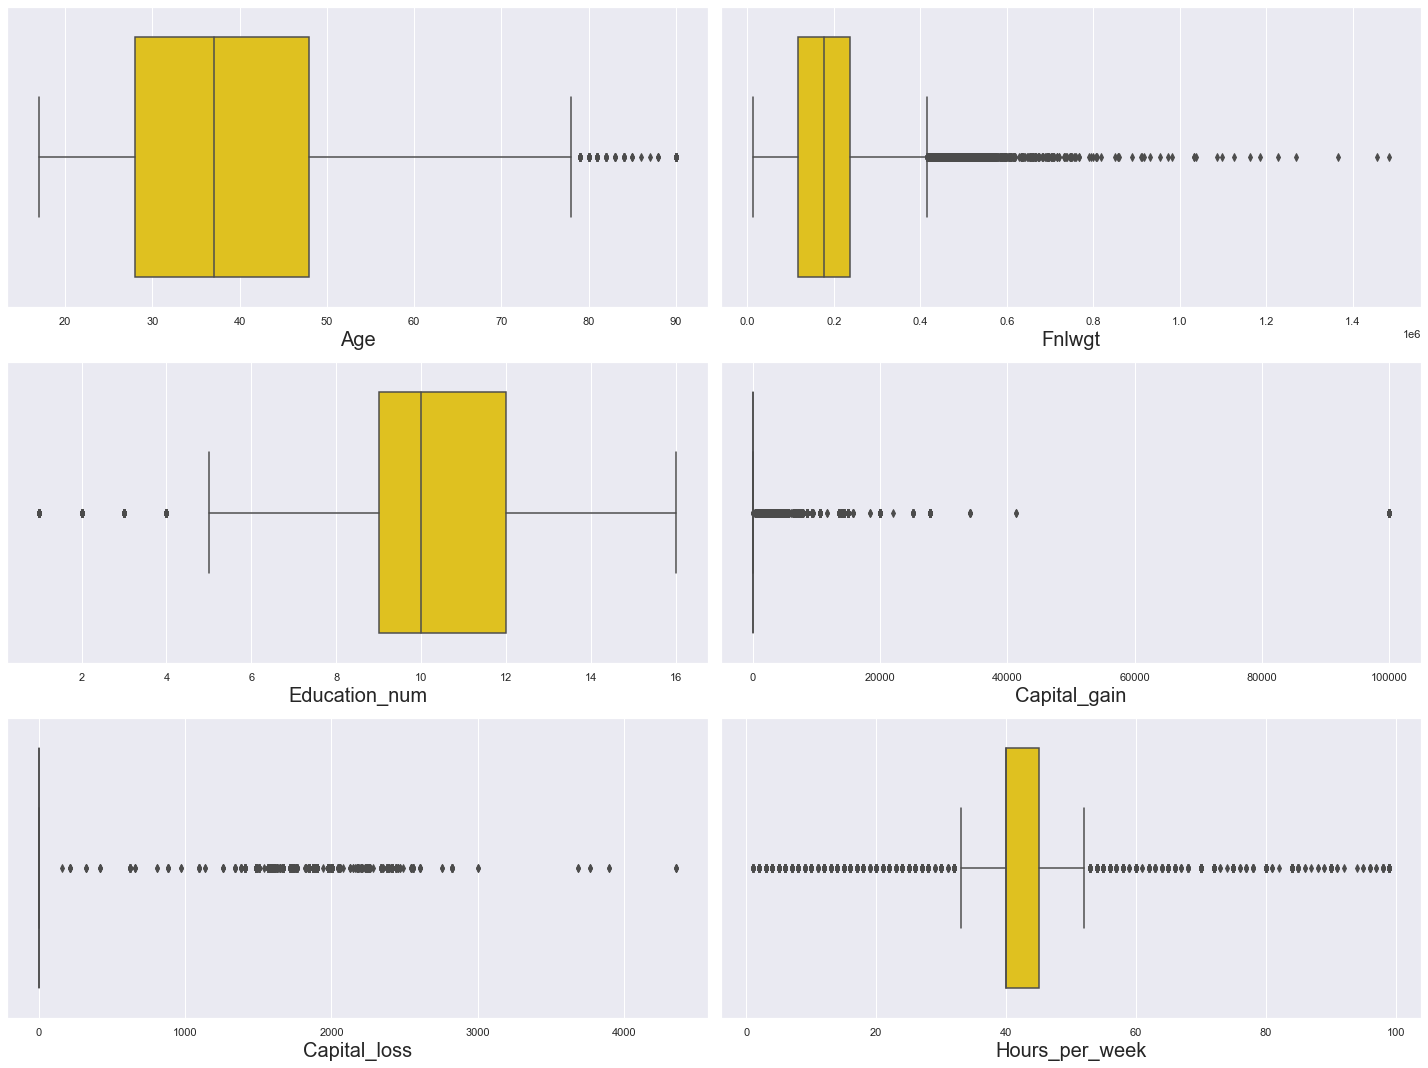

In [20]:
# Identifying the outliers using boxplot

plt.figure(figsize=(20,15),facecolor='white')
plotnumber=1
for column in numerical_columns:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.boxplot(df[column],color='gold')
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

Education_num     -0.309454
Hours_per_week     0.228752
Age                0.557657
Fnlwgt             1.447695
Capital_loss       4.592622
Capital_gain      11.949245
dtype: float64


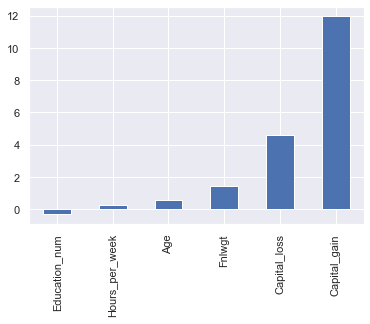

In [21]:
print(df.skew().sort_values())
df.skew().sort_values().plot(kind='bar')
plt.show()

In [22]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
numerics = ['int8','int16','int32','int64','float16','float32','float64']
categorical_columns = ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']
features=df.columns.values.tolist()

for col in features:
    if df[col].dtypes in numerics:
        continue
    df[col] = LabelEncoder().fit_transform(df[col])

df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
32556,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
32557,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
32558,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0


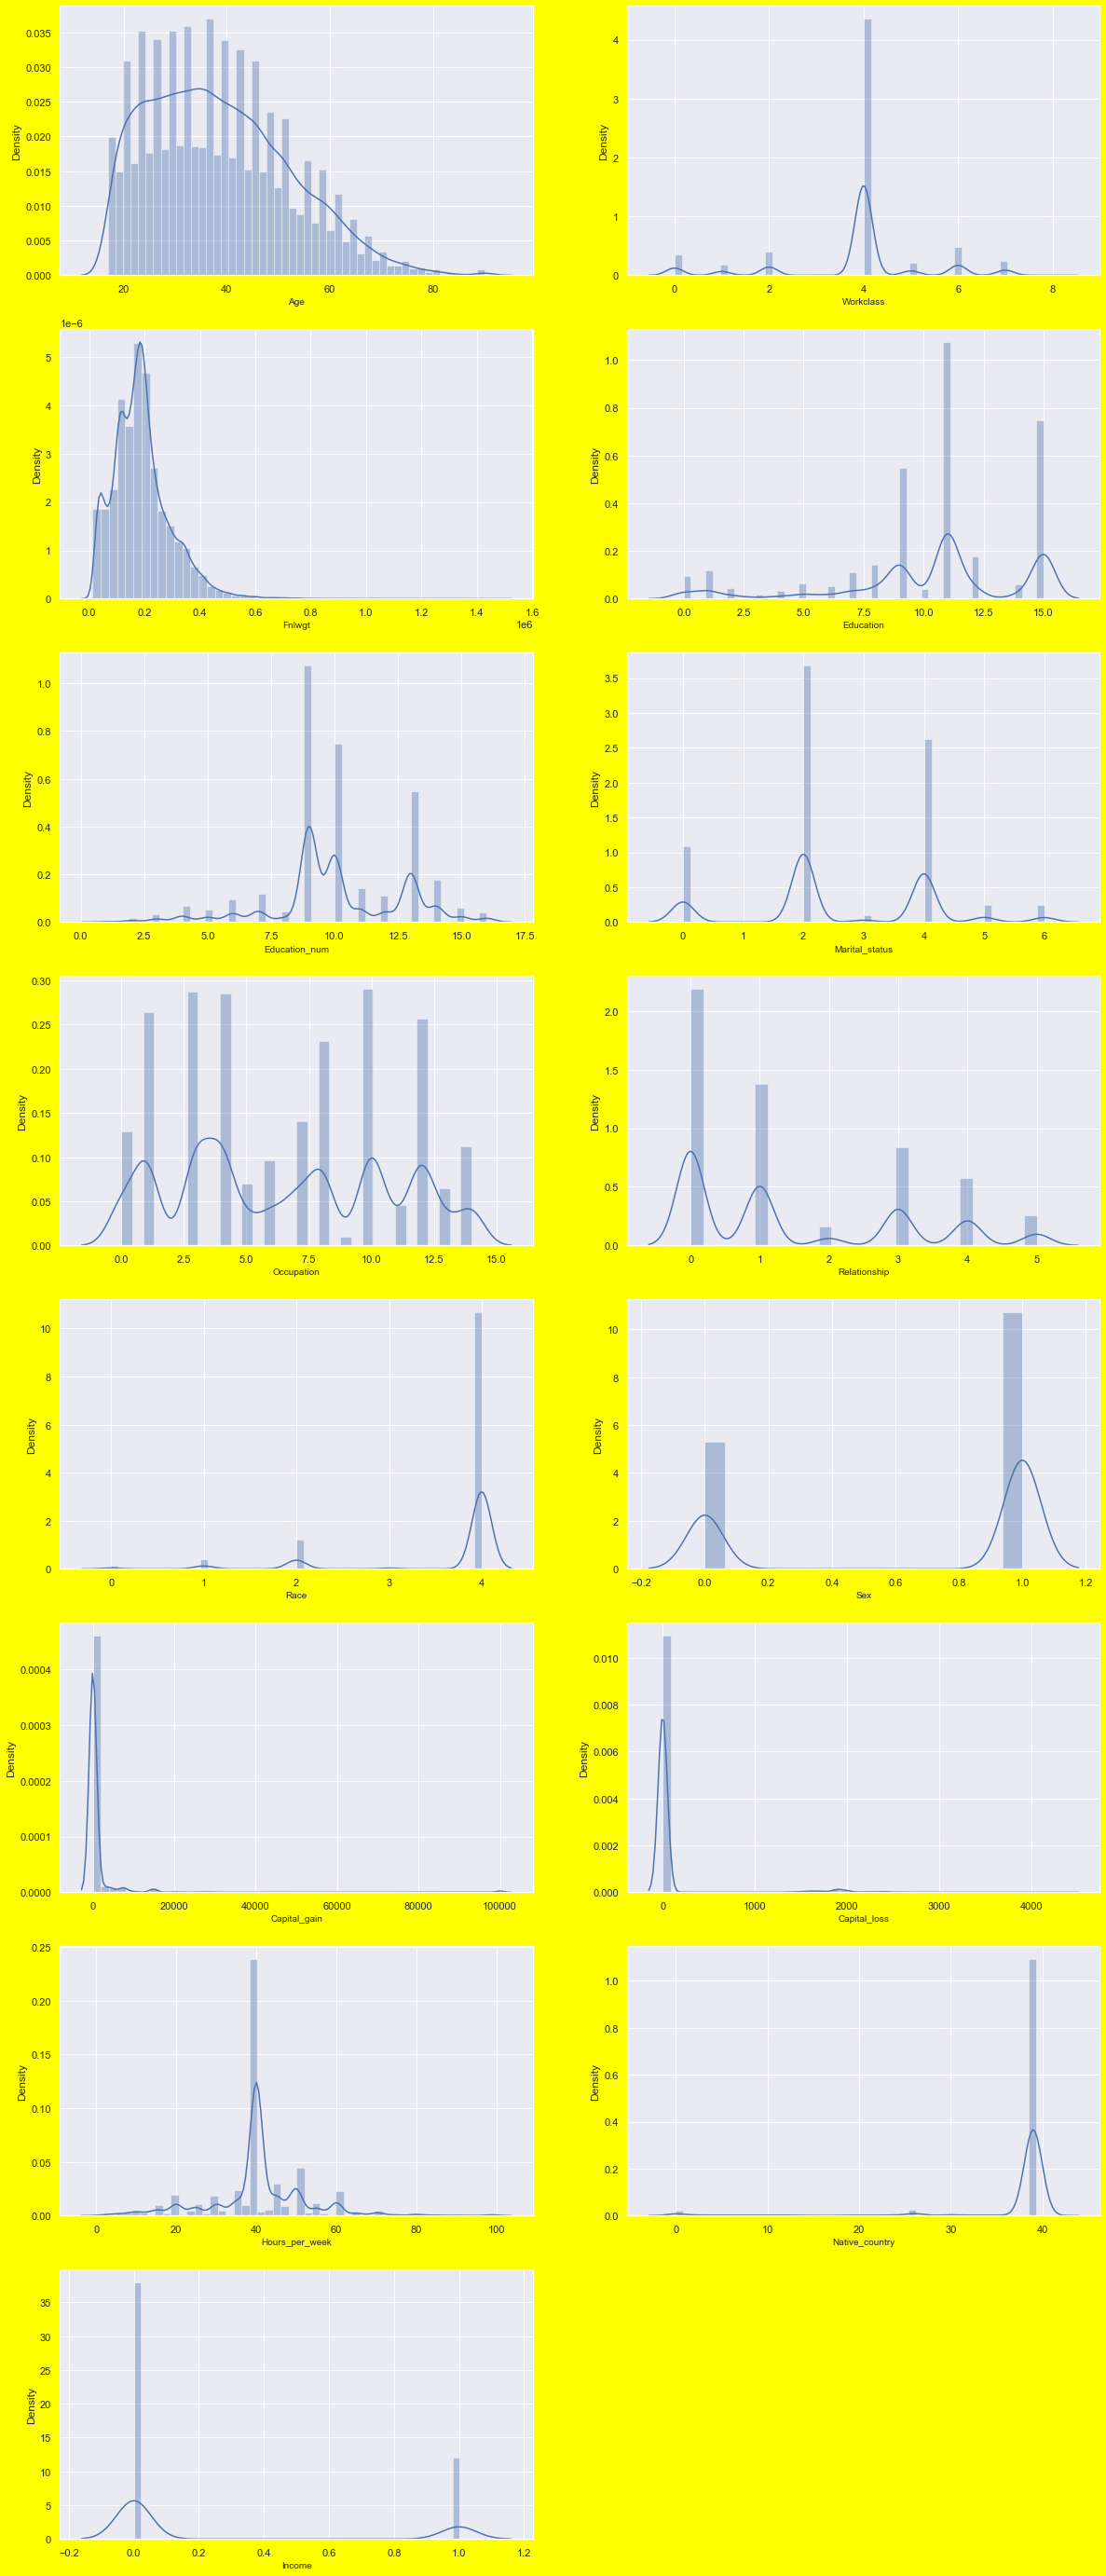

In [23]:
plt.figure(figsize=(20,50),facecolor="yellow")
plotnumber=1
for column in df:
    if plotnumber<=16:
        ax=plt.subplot(8,2,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

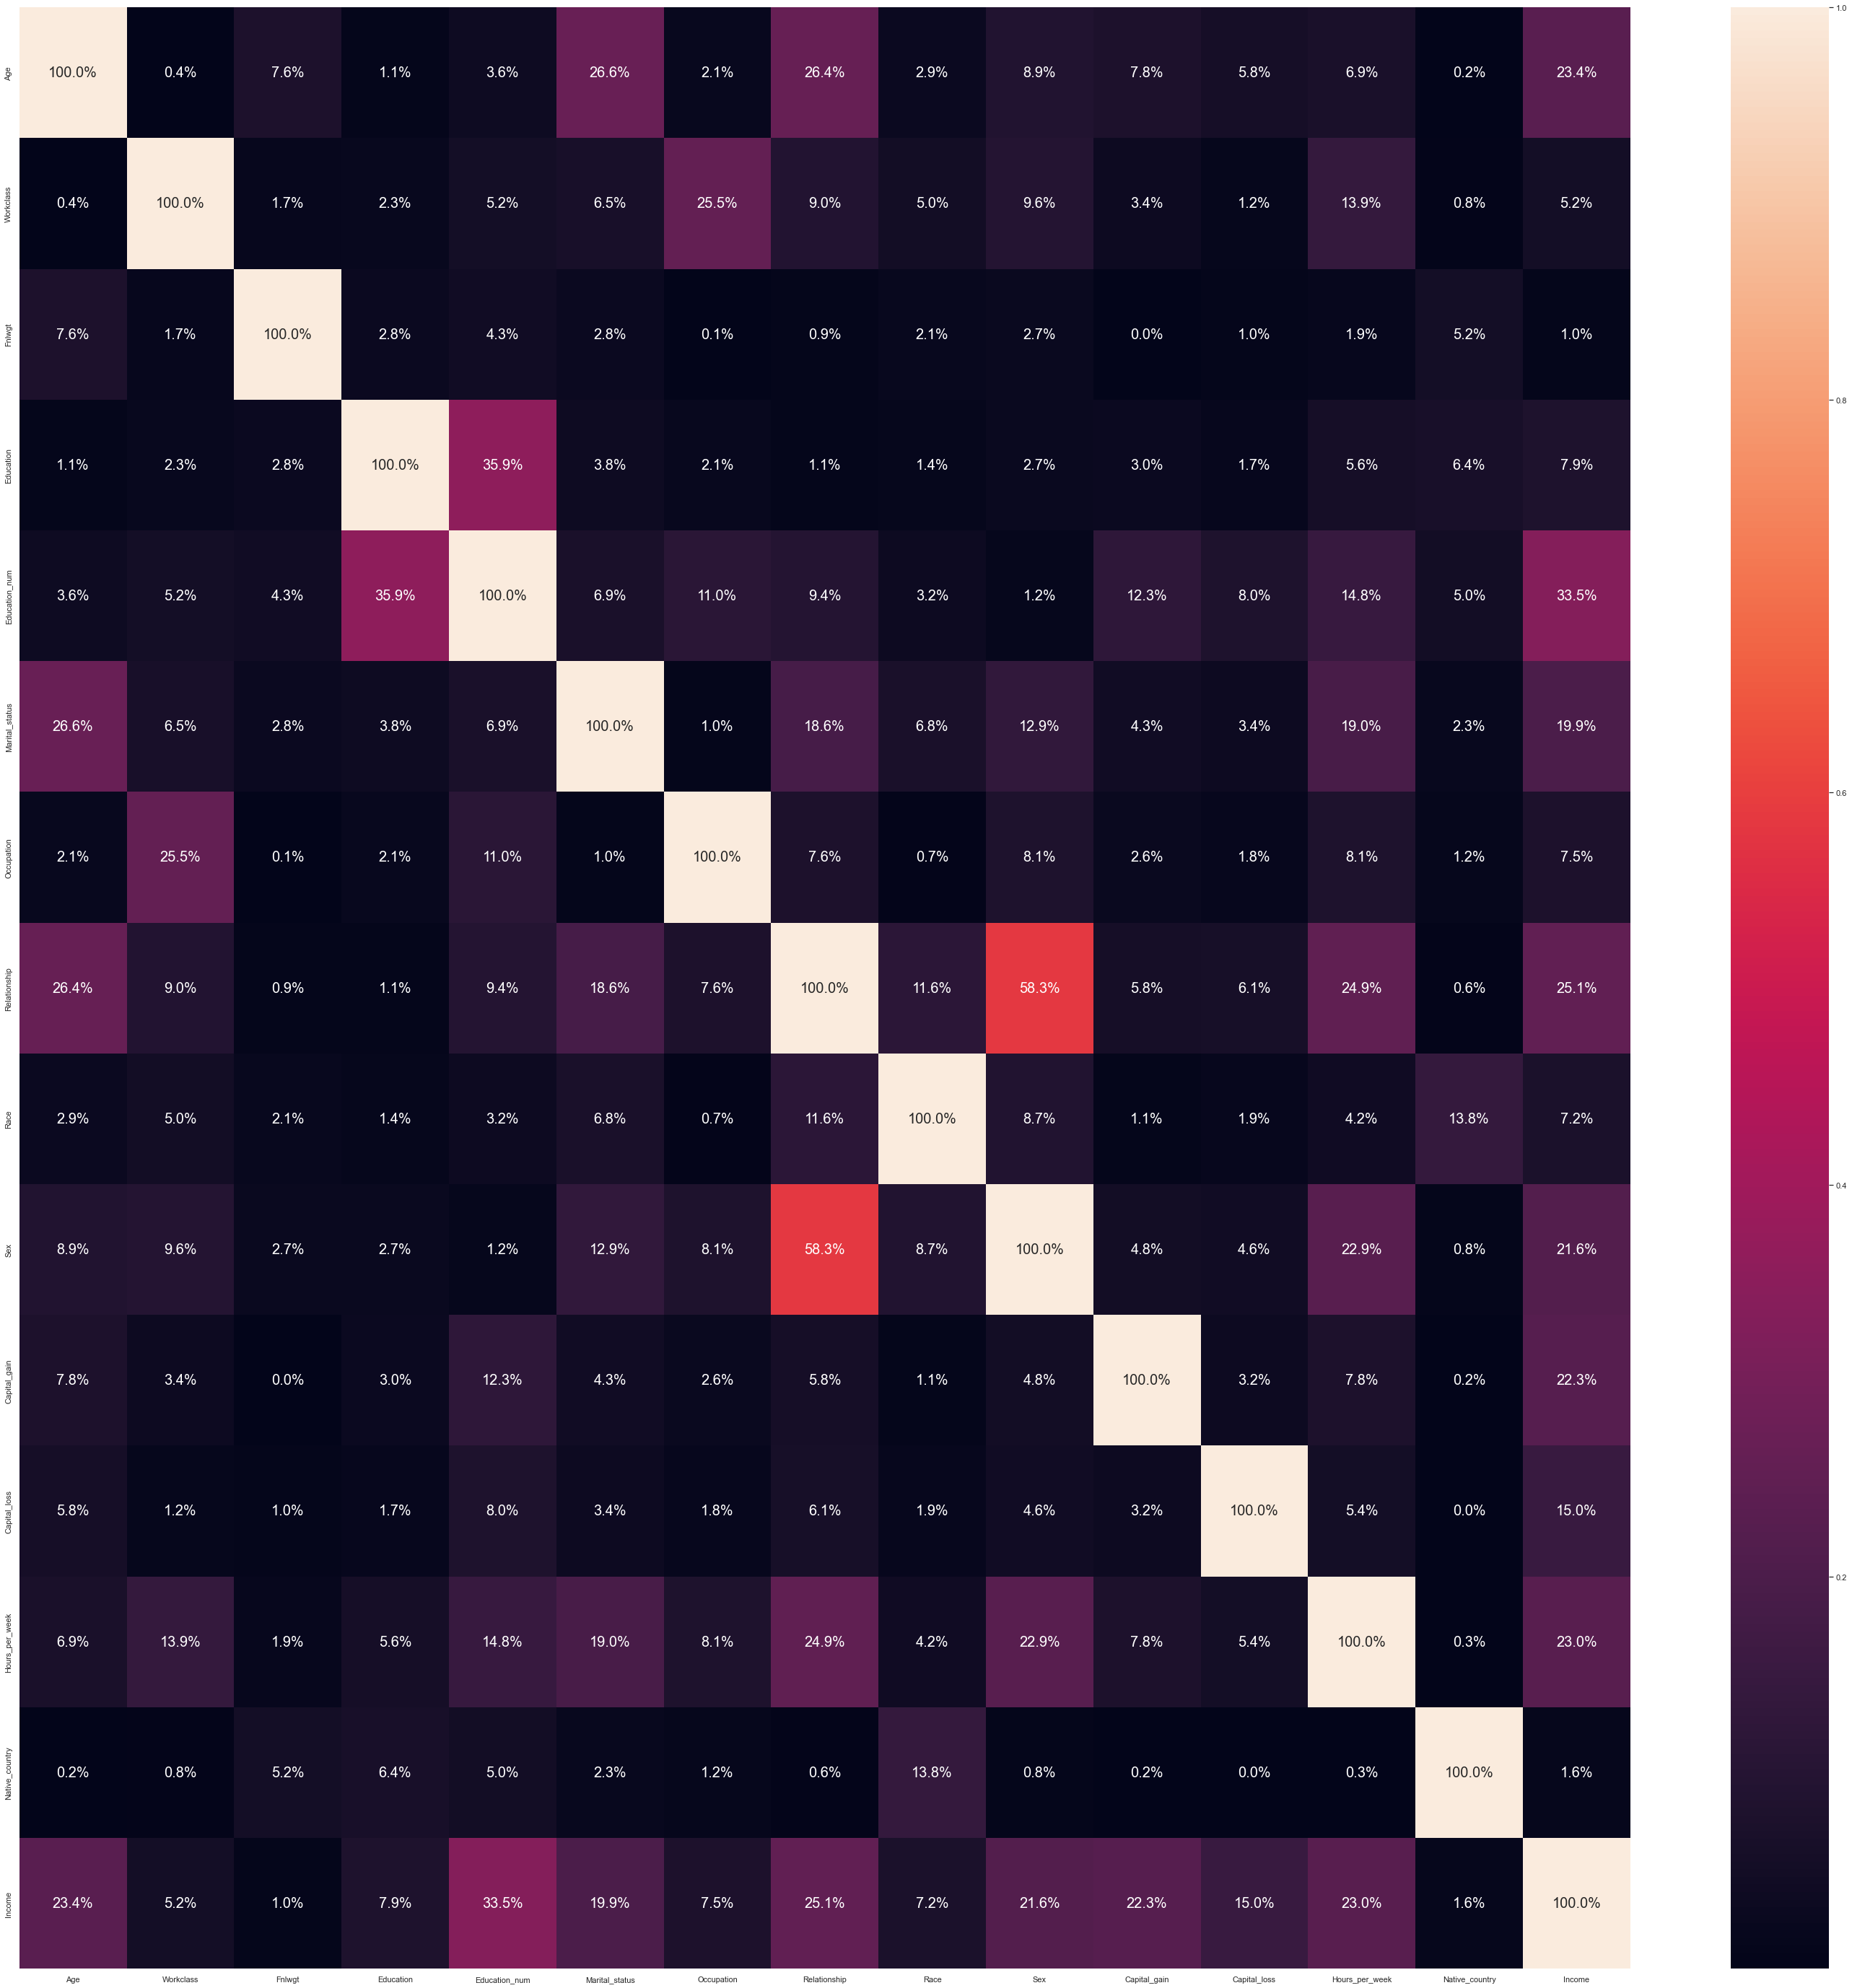

In [24]:
# Heat map to check the correlation 

df_corr=df.corr().abs()
plt.figure(figsize=(50,50))
sns.heatmap(df_corr,annot=True, annot_kws={'size':20}, fmt='.1%')
plt.show()

In [25]:
from scipy.stats import zscore
z= np.abs(zscore(df))

In [26]:
threshold= 3 
print(np.where(z>3))


(array([    3,     9,    10, ..., 32508, 32526, 32528], dtype=int64), array([13, 12,  8, ...,  8,  8,  8], dtype=int64))


In [27]:
df1=df[(z<3).all(axis=1)]
print(df.shape)
print(df1.shape)

(32536, 15)
(27399, 15)


In [28]:
df['Income'].value_counts()

0    24697
1     7839
Name: Income, dtype: int64

In [29]:
# Let us know split our data into Features & labels

x=df.drop('Income', axis=1)
y=df['Income']


In [30]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)


In [31]:
# Now let's split our data into Train_test_split

x_train, x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.25, random_state=44)



In [32]:
y_train.value_counts()

0    18485
1     5917
Name: Income, dtype: int64

In [33]:
sm=SMOTE()

In [34]:
ove_smp=SMOTE(0.75)

x_train_ns,y_train_ns = ove_smp.fit_resample(x_train,y_train)


In [35]:
y_train_ns.value_counts()

0    18485
1    13863
Name: Income, dtype: int64

### Now, let's start model building

In [36]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



In [37]:
classifiers = [GaussianNB(), 
               SVC(kernel = 'rbf', probability = True), 
               DecisionTreeClassifier(random_state = 0), 
               RandomForestClassifier(n_estimators = 100, random_state = 0), 
               GradientBoostingClassifier(random_state = 0)]
classifier_names = ["Gaussian Naive Bayes", 
                    "Support Vector Classifier", 
                    "Decision Tree Classifier", 
                    "Random Forest Classifier", 
                    "Gradient Boosting Classifier"]
accuracies = []


In [38]:
for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(x_train_ns, y_train_ns)
    y_pred = classifier.predict(x_test)
    print("{}:".format(classifier_names[i]))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)*100
    accuracies.append(accuracy)


Gaussian Naive Bayes:
F1 score: 0.54
Support Vector Classifier:
F1 score: 0.67
Decision Tree Classifier:
F1 score: 0.62
Random Forest Classifier:
F1 score: 0.68
Gradient Boosting Classifier:
F1 score: 0.70


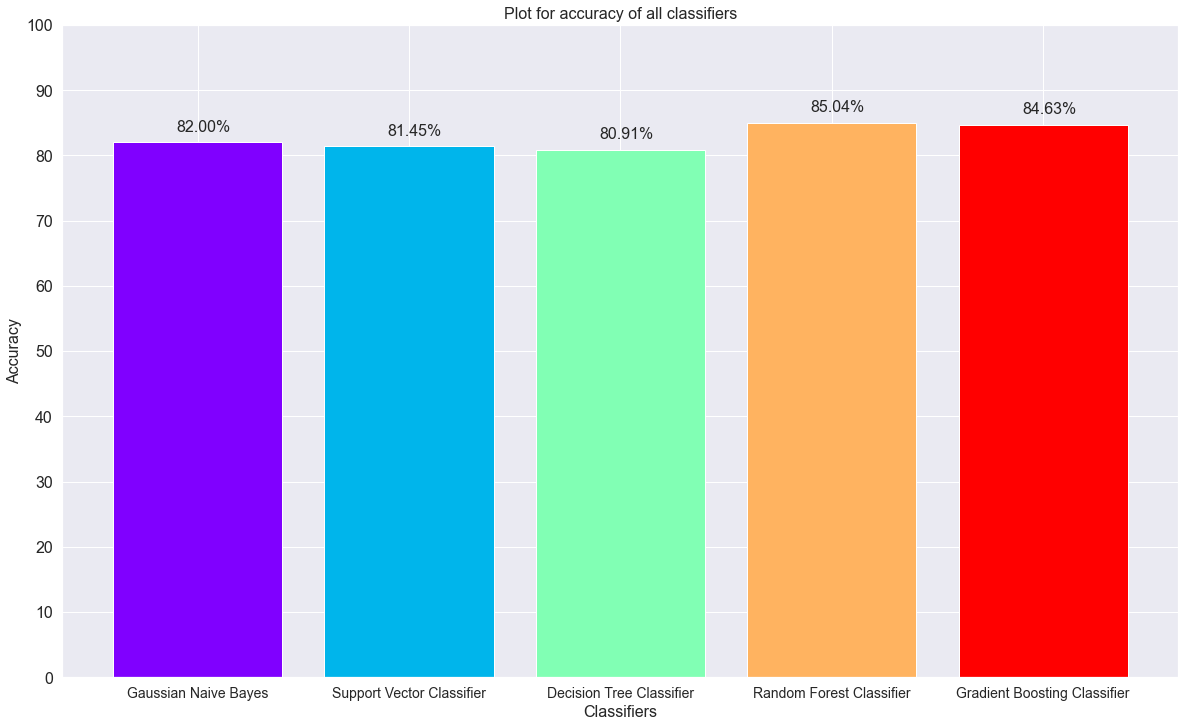

In [39]:
from matplotlib.cm import rainbow

plt.figure(figsize = (20, 12))
colors = rainbow(np.linspace(0, 1, len(classifiers)))
barplot = plt.bar(classifier_names, accuracies, color = colors)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize = 16)
plt.xticks(fontsize = 14)
plt.xlabel("Classifiers", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.title("Plot for accuracy of all classifiers", fontsize = 16)
for i, bar in enumerate(barplot):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, 
             bar.get_height()*1.02, 
             s = '{:.2f}%'.format(accuracies[i]), 
             fontsize = 16)


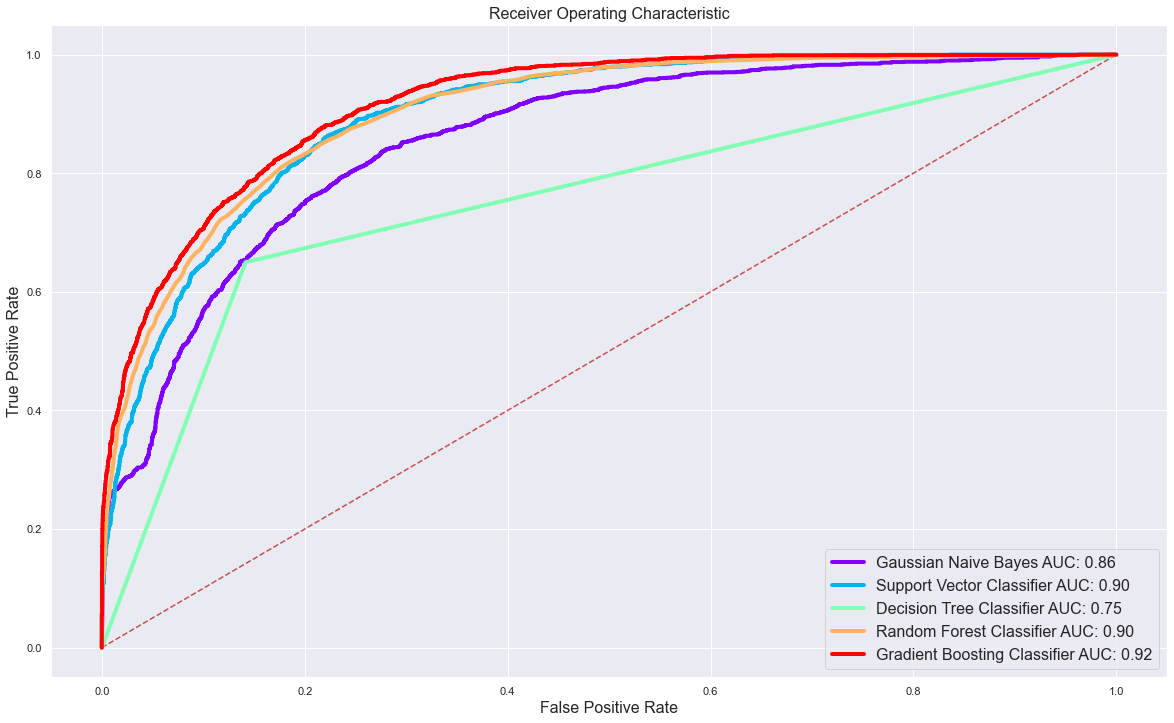

In [40]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for i in range(len(classifiers)):
    classifier = classifiers[i]
    probs = classifier.predict_proba(x_test)
    # Reading probability of second class
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    label = classifier_names[i] + ' AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = colors[i], label = label, linewidth = 4)
    
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)



In [42]:
#Saving the best model for future predictions
import pickle
filename='Census_Income_Project.pickle'
pickle.dump(GradientBoostingClassifier,open(filename,'wb'))


     